In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torchvision import models
from torch import nn, optim, cuda
from torchvision.transforms import transforms
to_tensor = transforms.ToTensor()

In [3]:
def add_coords_to_img(img_arr: np.array, coords: np.array) -> Image:
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    draw = ImageDraw.Draw(image)
    for point in coords:
        px = point.item(0)
        py = point.item(1)
        d = img_arr.shape[0] * 0.015
        draw.ellipse((px - d, py - d, px + d, py + d), fill="red")
    return image

In [4]:
MODEL_PATH = './data/weights/resnet50_regression_v2.2.3.pt'
NUM_CLASSES = 8

In [5]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval();

In [6]:
img = Image.open(f"data/trainset_128/{0:0>7}.png")
tensor = to_tensor(img).unsqueeze(0)

In [7]:
tensor.shape

torch.Size([1, 3, 128, 128])

In [8]:
%%time
predict_coords = model(tensor)
predict_coords = torch.split(predict_coords, 1, dim=1)
predict_coords = np.resize(predict_coords, (4,2))

CPU times: user 138 ms, sys: 28.4 ms, total: 167 ms
Wall time: 85.1 ms


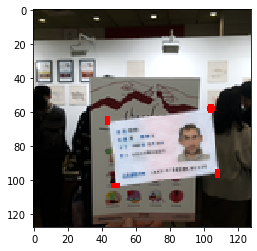

In [9]:
plt.imshow(add_coords_to_img(np.array(img), predict_coords));

# make pipeline

In [10]:
def load_model(weights_path: str = None):
    NUM_CLASSES = 8
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    MODEL_PATH = './data/weights/resnet50_regression_v2.2.3.pt'
    path = weights_path if weights_path else MODEL_PATH
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    
    return model

def predict_coords(model, tensor):
    predict_coords = model(tensor)
    predict_coords = torch.split(predict_coords, 1, dim=1)
    predict_coords = np.resize(predict_coords, (4,2))
    return predict_coords.astype('float32')

def get_card_coords(img: Image) -> np.array:
    model = load_model()
    tensor = to_tensor(img).unsqueeze(0)
    return predict_coords(model, tensor)

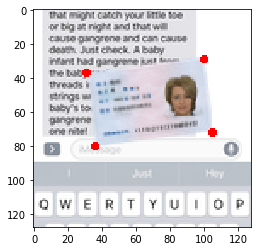

In [11]:
some_img = Image.open(f"data/trainset_128/{5:0>7}.png")
plt.imshow(add_coords_to_img(np.array(some_img), get_card_coords(some_img)));

# Lets crop card

In [12]:
coords = get_card_coords(some_img)

In [13]:
coords[1], coords[1][0]

(array([100.29889 ,  29.154207], dtype=float32), 100.29889)

In [14]:
import math

from utils import datasets

In [15]:
p1 = coords[0]
p2 = coords[1]
delta_x = p2[0] - p1[0]
delta_y = p2[1] - p1[1]
theta_radians = math.atan2(-delta_y, delta_x)

In [16]:
theta_radians

0.11649154635671256

In [17]:
coords

array([[ 31.599297,  37.193527],
       [100.29889 ,  29.154207],
       [ 36.697186,  80.47588 ],
       [105.409256,  72.40792 ]], dtype=float32)

In [18]:
center = coords.sum(axis=0) / 4

In [19]:
type(some_img)

PIL.PngImagePlugin.PngImageFile

In [20]:
im_arr = np.array(some_img)
shift_x = im_arr.shape[0]/2 - center[0]
shift_y = im_arr.shape[1]/2 - center[1]
im2 = datasets.shift_image(im_arr, shift_x, shift_y)
coords = datasets.shift_coords(coords, shift_x, shift_y)

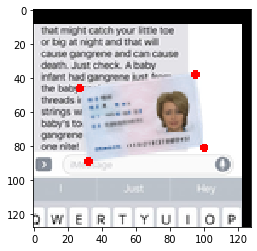

In [21]:
plt.imshow(add_coords_to_img(im2, coords));

In [22]:
angle = -theta_radians / math.pi * 180
im3 = datasets.rotate_image(im2, angle)
coords = datasets.rotate_coords(coords, angle, im2.shape)

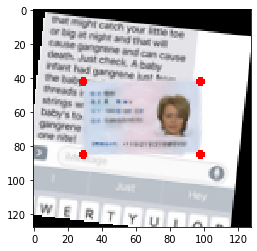

In [23]:
plt.imshow(add_coords_to_img(im3, coords));

In [24]:
coords

matrix([[29.39552416, 42.21598465],
        [98.56390364, 42.21598276],
        [29.4282296 , 85.79751475],
        [98.61233124, 85.7705165 ]])

In [25]:
a = coords.min(axis=0).astype(int)

In [26]:
b = coords.max(axis=0).astype(int)

In [27]:
a.item(0)

29

In [28]:
box = (a.item(0), a.item(1), b.item(0), b.item(1))

In [29]:
card = Image.fromarray(im3).crop(box)

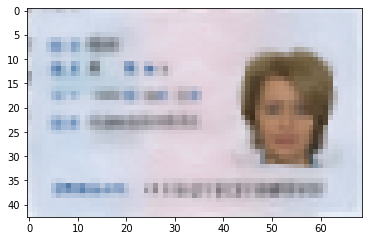

In [30]:
plt.imshow(card);

# make pipeline

In [34]:
def get_card(img, coords):
    img_arr = np.array(img)

    # shift
    center = coords.sum(axis=0) / 4
    shift_x = img_arr.shape[0]/2 - center[0]
    shift_y = img_arr.shape[1]/2 - center[1]
    img_arr = datasets.shift_image(img_arr, shift_x, shift_y)
    coords = datasets.shift_coords(coords, shift_x, shift_y)

    # rotate
    p1 = coords[0]
    p2 = coords[1]
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    theta_radians = math.atan2(-delta_y, delta_x)
    angle = -theta_radians / math.pi * 180
    img_arr = datasets.rotate_image(img_arr, angle)
    coords = datasets.rotate_coords(coords, angle, img_arr.shape)

    # crop
    a = coords.min(axis=0).astype(int)
    b = coords.max(axis=0).astype(int)
    box = (a.item(0), a.item(1), b.item(0), b.item(1))
    return Image.fromarray(img_arr).crop(box)

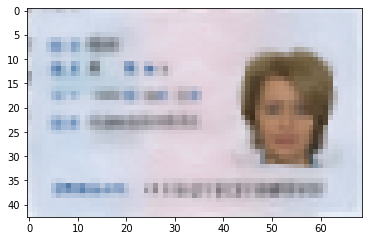

In [35]:
img = Image.open(f"data/trainset_128/{5:0>7}.png")
coords = get_card_coords(img)
card = get_card(img, coords)
plt.imshow(card);

# Scale down large image

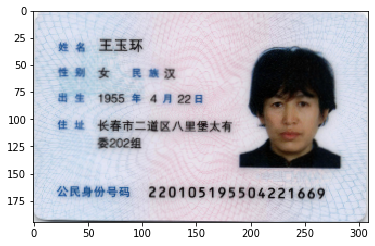

In [44]:
img = Image.open(f"data/train/original_sample_512.jpg")
img_128 = img.resize((128, 128), Image.ANTIALIAS)
img_w, _ = img.size
coords = get_card_coords(img_128) * (img_w / 128)
card = get_card(img, coords)
plt.imshow(card);